# NBO: прогноз следующего продукта

Цель: по истории покупок предсказать, какой продукт клиент купит следующим, и выдать топ-3 оффера по вероятности и ожидаемой выручке (вероятность × средняя цена продукта).


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

DATA_DIR = Path("/home/serge/Dev/mipt-mts-link-prakticum/data")


In [2]:
def load_data(data_dir: Path) -> dict:
    """Читает исходные таблицы и приводит даты."""
    basket = pd.read_csv(data_dir / "revenue-by-sale-date.csv")
    basket["sale_date"] = pd.to_datetime(basket["sale_date"])
    if "Unnamed: 0" in basket.columns:
        basket = basket.rename(columns={"Unnamed: 0": "row_idx"})
    companies = pd.read_csv(data_dir / "companies.csv")
    if "Unnamed: 0" in companies.columns:
        companies = companies.rename(columns={"Unnamed: 0": "row_idx"})
    rfm = pd.read_csv(data_dir / "rfm.csv")
    rfm_feat = pd.read_csv(data_dir / "rfm-features.csv")
    return {"basket": basket, "companies": companies, "rfm": rfm, "rfm_feat": rfm_feat}


data = load_data(DATA_DIR)
data.keys()


dict_keys(['basket', 'companies', 'rfm', 'rfm_feat'])

In [3]:
def build_next_product_dataset(data: dict) -> tuple[pd.DataFrame, pd.Series]:
    """Готовит выборку: таргет = следующий купленный продукт."""
    basket = data["basket"].copy()
    rfm = data["rfm"].copy()
    rfm_feat = data["rfm_feat"].copy()
    companies = data["companies"].copy()

    basket["sale_type"] = basket["sale_type"].fillna("Unknown")
    basket["product_name"] = basket["product_name"].fillna("Unknown")

    basket = basket.sort_values(["company_id", "sale_date"])
    basket["prev_product"] = basket.groupby("company_id")["product_name"].shift(1).fillna("None")
    basket["prev_sale_type"] = basket.groupby("company_id")["sale_type"].shift(1).fillna("None")
    basket["days_since_prev"] = (
        basket.groupby("company_id")["sale_date"].diff().dt.days.fillna(-1)
    )
    basket["next_product"] = basket.groupby("company_id")["product_name"].shift(-1)
    basket = basket.dropna(subset=["next_product"])

    df = (
        basket
        .merge(rfm, on="company_id", how="left", suffixes=('', '_rfm'))
        .merge(
            rfm_feat,
            on=["company_id", "first_purchase", "last_purchase", "frequency", "monetary", "recency", "customer_age_days"],
            how="left",
            suffixes=('', '_feat')
        )
        .merge(companies.drop(columns=["row_idx"], errors="ignore"), on="company_id", how="left")
    )

    df[["Возврат", "Новая", "Продление", "Расширение"]] = df[["Возврат", "Новая", "Продление", "Расширение"]].fillna(0)

    target = df["next_product"].reset_index(drop=True)
    features = df.drop(columns=["next_product", "row_idx", "row_id", "sale_id"], errors="ignore").reset_index(drop=True)
    return features, target


features, target = build_next_product_dataset(data)
features.shape, target.nunique()


((14702, 32), 26)

In [4]:
def train_val_split(features: pd.DataFrame, target: pd.Series, cutoff: str = "2023-01-01"):
    """Делит по времени: до cutoff — train, после — val."""
    cutoff_ts = pd.Timestamp(cutoff)
    mask_train = features["sale_date"] < cutoff_ts
    X_train = features.loc[mask_train].copy()
    y_train = target.loc[mask_train].reset_index(drop=True)
    X_val = features.loc[~mask_train].copy()
    y_val = target.loc[~mask_train].reset_index(drop=True)
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = train_val_split(features, target)
X_train.shape, X_val.shape


((13481, 32), (1221, 32))

In [5]:
def prepare_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list[str], list[str]]:
    """Готовит признаки: заполняет пропуски, приводит категории."""
    work = df.copy()
    drop_cols = ["sale_date", "sale_year_month", "company_id"]
    work = work.drop(columns=drop_cols, errors="ignore")

    cat_cols = work.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in work.columns if c not in cat_cols]

    for col in cat_cols:
        work[col] = work[col].fillna("Unknown").astype("category")
    for col in num_cols:
        work[col] = work[col].astype(float)
        work[col] = work[col].fillna(work[col].median())

    return work, cat_cols, num_cols


X_train_prep, cat_cols, num_cols = prepare_features(X_train)
X_val_prep, _, _ = prepare_features(X_val)
cat_cols


['product_name',
 'sale_type',
 'prev_product',
 'prev_sale_type',
 'first_purchase',
 'last_purchase',
 'sector',
 'segment',
 'industry',
 'company_size']

In [6]:
y_train_cat = pd.Categorical(y_train)
y_val_cat = pd.Categorical(y_val, categories=y_train_cat.categories)
classes = list(y_train_cat.categories)

y_train_codes = y_train_cat.codes
y_val_codes = y_val_cat.codes
classes[:5], len(classes)


(['Enterprise Total-1000',
  'Enterprise Total-150',
  'Enterprise Total-2000',
  'Enterprise Total-300',
  'Enterprise Total-3000'],
 26)

In [7]:
lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(classes),
    learning_rate=0.05,
    n_estimators=400,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
)

lgbm.fit(
    X_train_prep,
    y_train_codes,
    eval_set=[(X_val_prep, y_val_codes)],
    eval_metric="multi_logloss",
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
)



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 13481, number of used features: 29
[LightGBM] [Info] Start training from score -4.696852
[LightGBM] [Info] Start training from score -4.539223
[LightGBM] [Info] Start training from score -5.414692
[LightGBM] [Info] Start training from score -4.421440
[LightGBM] [Info] Start training from score -6.107839
[LightGBM] [Info] Start training from score -4.633839
[LightGBM] [Info] Start training from score -6.330983
[LightGBM] [Info] Start training from 

,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,400
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [8]:
def topk_accuracy(probs: np.ndarray, true_labels: pd.Series, class_list: list[str], k: int = 3) -> float:
    """Доля примеров, где верный продукт попал в топ-k."""
    true_idx = pd.Categorical(true_labels, categories=class_list).codes
    topk = np.argsort(-probs, axis=1)[:, :k]
    hits = sum(t in row for t, row in zip(true_idx, topk))
    return hits / len(true_labels)


def mapk(probs: np.ndarray, true_labels: pd.Series, class_list: list[str], k: int = 3) -> float:
    """Средняя обратная позиция верного продукта в топ-k."""
    true_idx = pd.Categorical(true_labels, categories=class_list).codes
    topk = np.argsort(-probs, axis=1)[:, :k]
    gains = []
    for t, row in zip(true_idx, topk):
        if t in row:
            gains.append(1 / (list(row).index(t) + 1))
        else:
            gains.append(0.0)
    return float(np.mean(gains))


def expected_profit_at_k(probs: np.ndarray, mean_price: np.ndarray, k: int = 3) -> float:
    """Средняя ожидаемая выручка prob×price по топ-k."""
    topk_idx = np.argsort(-probs, axis=1)[:, :k]
    exp_list = []
    for i, row in enumerate(topk_idx):
        exp_list.append((probs[i, row] * mean_price[row]).sum())
    return float(np.mean(exp_list))



In [9]:
probs_val = lgbm.predict_proba(X_val_prep)

print(f"Top-1 Accuracy: {topk_accuracy(probs_val, y_val, classes, k=1):.3f}")
print(f"Top-3 Accuracy: {topk_accuracy(probs_val, y_val, classes, k=3):.3f}")
print(f"MAP@3:          {mapk(probs_val, y_val, classes, k=3):.3f}")


Top-1 Accuracy: 0.643
Top-3 Accuracy: 0.907
MAP@3:          0.767


In [10]:
mean_price = (
    data["basket"]
    .groupby("product_name")["product_sum"]
    .mean()
    .reindex(classes)
    .fillna(0)
    .to_numpy()
)

print(f"Expected Profit@3: {expected_profit_at_k(probs_val, mean_price, k=3):,.0f} руб.")


Expected Profit@3: 13,192 руб.


## Бизнес-анализ качества модели


In [11]:
# 1. Baseline: случайный выбор
n_classes = len(classes)
random_top1_accuracy = 1 / n_classes
random_top3_accuracy = min(3 / n_classes, 1.0)

print("=== Сравнение с baseline (случайный выбор) ===")
print(f"Random Top-1 Accuracy: {random_top1_accuracy:.3f}")
print(f"Random Top-3 Accuracy: {random_top3_accuracy:.3f}")
print()
print(f"Lift Top-1: {topk_accuracy(probs_val, y_val, classes, k=1) / random_top1_accuracy:.1f}x")
print(f"Lift Top-3: {topk_accuracy(probs_val, y_val, classes, k=3) / random_top3_accuracy:.1f}x")


=== Сравнение с baseline (случайный выбор) ===
Random Top-1 Accuracy: 0.038
Random Top-3 Accuracy: 0.115

Lift Top-1: 16.7x
Lift Top-3: 7.9x


In [12]:
# 2. Дисбаланс классов в таргете
class_distribution = y_val.value_counts(normalize=True).head(10)
print("=== Распределение классов в валидации (топ-10) ===")
for cls, pct in class_distribution.items():
    print(f"  {cls}: {pct:.1%}")

# Naive baseline: всегда предлагать самый частый класс
most_frequent_class = y_val.value_counts().idxmax()
naive_accuracy = (y_val == most_frequent_class).mean()
print(f"\nNaive baseline (всегда '{most_frequent_class}'): {naive_accuracy:.3f}")
print(f"Наша модель лучше naive на: {topk_accuracy(probs_val, y_val, classes, k=1) - naive_accuracy:.3f}")


=== Распределение классов в валидации (топ-10) ===
  Расширения: 48.6%
  Тарифы Webinar СМБ: 28.3%
  Доски: 4.2%
  Чаты: 3.7%
  МТС Линк. Компания: 2.0%
  Общие Тарифы Webinar Enterprise: 2.0%
  Enterprise-300: 1.7%
  Enterprise-500: 1.5%
  Enterprise-150: 1.4%
  Enterprise-100: 0.9%

Naive baseline (всегда 'Расширения'): 0.486
Наша модель лучше naive на: 0.156


In [13]:
# 3. Анализ по сегментам клиентов (high-value vs остальные)
val_monetary = X_val["monetary"].reset_index(drop=True)
high_value_threshold = val_monetary.quantile(0.75)
high_value_mask = val_monetary >= high_value_threshold

print("=== Качество по сегментам ===")
print(f"High-value клиенты (monetary >= {high_value_threshold:,.0f}):")
print(f"  Доля в выборке: {high_value_mask.mean():.1%}")
print(f"  Top-3 Accuracy: {topk_accuracy(probs_val[high_value_mask], y_val[high_value_mask], classes, k=3):.3f}")

low_value_mask = ~high_value_mask
print(f"\nОстальные клиенты:")
print(f"  Доля в выборке: {low_value_mask.mean():.1%}")
print(f"  Top-3 Accuracy: {topk_accuracy(probs_val[low_value_mask], y_val[low_value_mask], classes, k=3):.3f}")


=== Качество по сегментам ===
High-value клиенты (monetary >= 427,000):
  Доля в выборке: 25.1%
  Top-3 Accuracy: 0.941

Остальные клиенты:
  Доля в выборке: 74.9%
  Top-3 Accuracy: 0.896


In [14]:
# 4. Expected Profit vs baseline
random_expected_profit = mean_price.mean() * 3  # случайный топ-3
model_expected_profit = expected_profit_at_k(probs_val, mean_price, k=3)

print("=== Expected Profit ===")
print(f"Random baseline:  {random_expected_profit:,.0f} руб.")
print(f"Наша модель:      {model_expected_profit:,.0f} руб.")
print(f"Lift:             {model_expected_profit / random_expected_profit:.2f}x")


=== Expected Profit ===
Random baseline:  106,303 руб.
Наша модель:      13,192 руб.
Lift:             0.12x


In [15]:
# 5. Coverage каталога: какие продукты модель рекомендует?
top1_predictions = [classes[i] for i in probs_val.argmax(axis=1)]
recommended_products = set(top1_predictions)
print("=== Coverage каталога ===")
print(f"Всего продуктов в каталоге: {len(classes)}")
print(f"Модель рекомендует:         {len(recommended_products)} продуктов")
print(f"Coverage:                   {len(recommended_products) / len(classes):.1%}")

# Какие продукты НЕ рекомендуются?
not_recommended = set(classes) - recommended_products
if not_recommended:
    print(f"\nПродукты без рекомендаций ({len(not_recommended)}):")
    for p in list(not_recommended)[:5]:
        print(f"  - {p}")
    if len(not_recommended) > 5:
        print(f"  ... и ещё {len(not_recommended) - 5}")


=== Coverage каталога ===
Всего продуктов в каталоге: 26
Модель рекомендует:         19 продуктов
Coverage:                   73.1%

Продукты без рекомендаций (7):
  - Enterprise Total-3000
  - Enterprise Total-2000
  - Enterprise Total-5000
  - Тарифы TMS
  - Enterprise Total-500
  ... и ещё 2


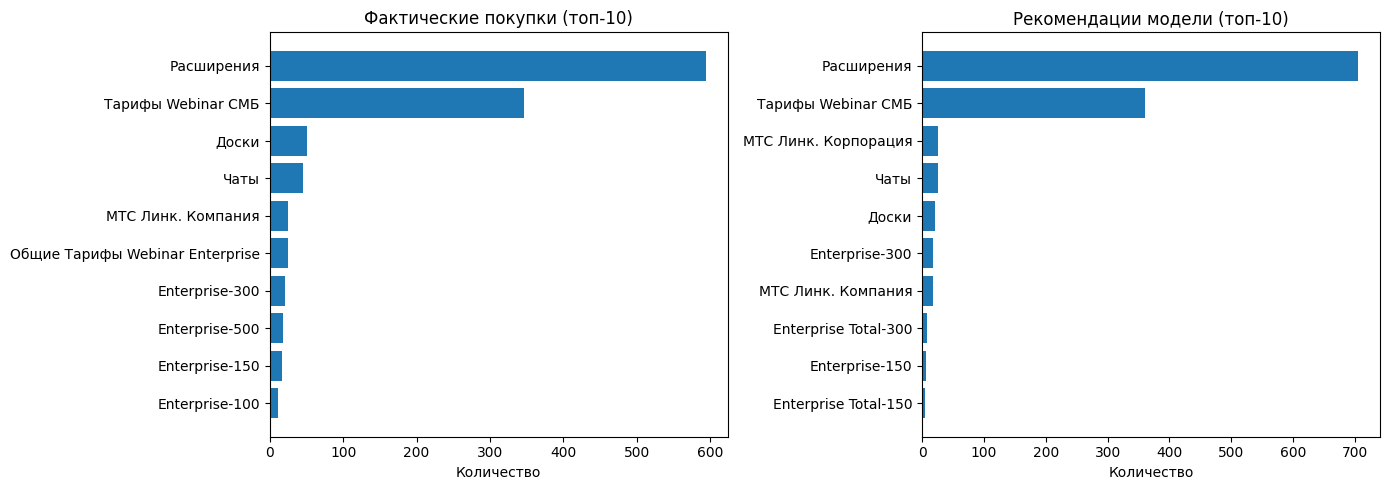

In [16]:
# 6. Распределение рекомендуемых продуктов
import matplotlib.pyplot as plt

pred_counts = pd.Series(top1_predictions).value_counts()
actual_counts = y_val.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Факт
axes[0].barh(actual_counts.head(10).index[::-1], actual_counts.head(10).values[::-1])
axes[0].set_title("Фактические покупки (топ-10)")
axes[0].set_xlabel("Количество")

# Рекомендации
axes[1].barh(pred_counts.head(10).index[::-1], pred_counts.head(10).values[::-1])
axes[1].set_title("Рекомендации модели (топ-10)")
axes[1].set_xlabel("Количество")

plt.tight_layout()
plt.show()


## Важность признаков


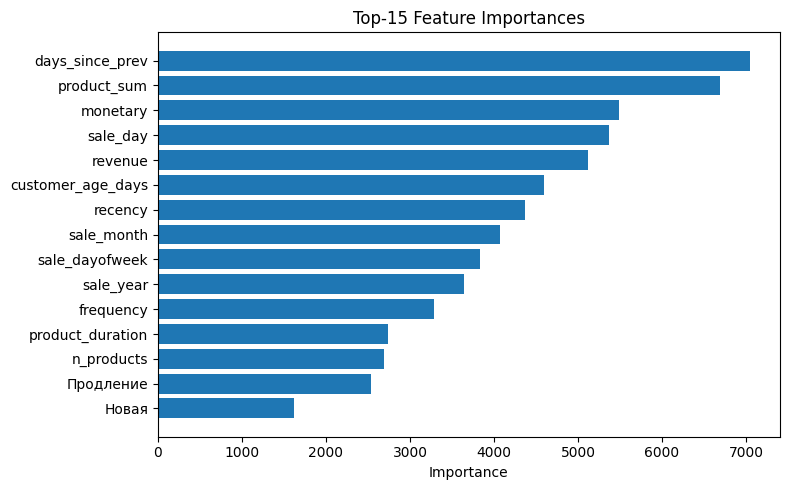

In [17]:
import matplotlib.pyplot as plt

feat_imp = pd.DataFrame({
    "feature": X_train_prep.columns,
    "importance": lgbm.feature_importances_,
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top-15 Feature Importances")
plt.tight_layout()
plt.show()


## Инференс: топ-3 оффера для каждого клиента


In [18]:
def get_latest_per_company(features: pd.DataFrame) -> pd.DataFrame:
    """Берёт последнюю покупку каждой компании для рекомендации следующего шага."""
    idx = features.groupby("company_id")["sale_date"].idxmax()
    return features.loc[idx].copy()


latest = get_latest_per_company(features)
latest_prep, _, _ = prepare_features(latest)
latest_probs = lgbm.predict_proba(latest_prep)
latest.shape, latest_probs.shape


((1681, 32), (1681, 26))

In [19]:
def make_topk_recommendations(
    probs: np.ndarray,
    source: pd.DataFrame,
    class_list: list[str],
    mean_price: np.ndarray,
    k: int = 3,
) -> pd.DataFrame:
    """Создаёт таблицу топ-k рекомендаций с вероятностью и ожидаемой выручкой."""
    top_idx = np.argsort(-probs, axis=1)[:, :k]
    rows = []
    for i, company in enumerate(source["company_id"].values):
        for rank in range(k):
            cls_idx = top_idx[i, rank]
            rows.append({
                "company_id": company,
                "rank": rank + 1,
                "offer_product": class_list[cls_idx],
                "prob": probs[i, cls_idx],
                "expected_revenue": probs[i, cls_idx] * mean_price[cls_idx],
            })
    return pd.DataFrame(rows)


nbo_recs = make_topk_recommendations(latest_probs, latest, classes, mean_price, k=3)
nbo_recs.head(9)


,company_id,rank,offer_product,prob,expected_revenue
0,comp_001eac7794df,1,Тарифы Webinar СМБ,0.981131,11321.731246
1,comp_001eac7794df,2,Расширения,0.011987,149.818560
2,comp_001eac7794df,3,Enterprise-300,0.001003,19.278979
3,comp_002f5166d79b,1,Расширения,0.576512,7205.371867
4,comp_002f5166d79b,2,Тарифы Webinar СМБ,0.315455,3640.182612
5,comp_002f5166d79b,3,Enterprise-500,0.045988,919.393952
6,comp_003be29c3721,1,МТС Линк. Корпорация,0.644038,16656.144028
7,comp_003be29c3721,2,Доски,0.195117,3126.848028
8,comp_003be29c3721,3,МТС Линк. Компания,0.052900,604.145825


In [20]:
print("Топ-3 офферов для каждого клиента:")
print(f"  Уникальных клиентов:   {nbo_recs['company_id'].nunique():,}")
print(f"  Всего рекомендаций:    {len(nbo_recs):,}")
print(f"  Средняя вероятность:   {nbo_recs['prob'].mean():.3f}")
print(f"  Средняя ожид. выручка: {nbo_recs['expected_revenue'].mean():,.0f} руб.")


Топ-3 офферов для каждого клиента:
  Уникальных клиентов:   1,681
  Всего рекомендаций:    5,043
  Средняя вероятность:   0.318
  Средняя ожид. выручка: 4,597 руб.


In [21]:
output_path = Path("/home/serge/Dev/mipt-mts-link-prakticum/CDA/nbo_recs.csv")
nbo_recs.to_csv(output_path, index=False)
print(f"Рекомендации сохранены в {output_path}")


Рекомендации сохранены в /home/serge/Dev/mipt-mts-link-prakticum/CDA/nbo_recs.csv


## Резюме

Модель NBO без прогноза LTV:
- Таргет: следующий продукт, который купит клиент
- Признаки: RFM, история покупок, предыдущий продукт, тип сделки, данные о компании
- Метрики: Top-1/Top-3 Accuracy, MAP@3, Expected Profit@3
- Выход: топ-3 оффера для каждого клиента с вероятностями и ожидаемой выручкой

Файл `nbo_recs.csv` содержит рекомендации для использования в CRM/маркетинге.
